In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator

In [2]:
merge_df = pd.read_csv('处理过的全量数据.csv', index_col=['day', 'id'])

In [3]:
def min_400_stock(df):
    """
    本函数用于找到每日市值最低的400只股票，其中要剔除sign为-1的股票以及上市未满7天的股票。
    :param df: 输入Dataframe，这里是merge_df
    :return: 每日市值最低的400只股票组成的Dataframe
    """
    # 创建一个空的 Series
    min_400_stocks_series = pd.Series(dtype=object)
    min_1_to_100_stocks_series = pd.Series(dtype=object)
    min_101_to_200_stocks_series = pd.Series(dtype=object)
    min_201_to_300_stocks_series = pd.Series(dtype=object)
    min_301_to_400_stocks_series = pd.Series(dtype=object)

#     # 获取7个交易日内市值不为0的数据
#     df['market value_nonzero_7days'] = df.groupby(level=1)['value'].rolling(7).apply(lambda x: (x != 0).any()).reset_index(level=0, drop=True)

    # 筛选出sign为1.0且过去7个交易日内市值不为0的数据，并按日期进行分组
#     sign_1_nonzero_7days = df[(merge_df['sign'] == 1.0) & (df['market value_nonzero_7days'] == True)].groupby(level=0)


    # 筛选出非0市值的数据，同时sign为1.0的数据，并按日期进行分组
    sign_1_nonzero = df[(df['value'] != 0) & (df['sign'] == 1.0)].groupby(level=0)

   
    # 遍历每个日期的数据
    for date, group in sign_1_nonzero:
        # 获取当前日期股票市值最低的400只股票的名字
        min_400 = group.nsmallest(400, 'value').index.get_level_values('id').tolist()
        min_1_to_100 = group.nsmallest(100, 'value').index.get_level_values('id').tolist()
        min_101_to_200 = group.nsmallest(200, 'value').nlargest(100, 'value').index.get_level_values('id').tolist()
        min_201_to_300 = group.nsmallest(300, 'value').nlargest(100, 'value').index.get_level_values('id').tolist()
        min_301_to_400 = group.nsmallest(400, 'value').nlargest(100, 'value').index.get_level_values('id').tolist()

        # 将当前日期的股票数据存储在 Series 中，日期作为索引
        min_400_stocks_series[date] = min_400
        min_1_to_100_stocks_series[date] = min_1_to_100
        min_101_to_200_stocks_series[date] = min_101_to_200
        min_201_to_300_stocks_series[date] = min_201_to_300
        min_301_to_400_stocks_series[date] = min_301_to_400
        
    min_400_stocks = pd.DataFrame(min_400_stocks_series)
    min_400_stocks.index = pd.to_datetime(min_400_stocks.index)
    min_400_stocks.sort_index(ascending=True, inplace=True)
    min_400_stocks.index = min_400_stocks.index.strftime('%Y-%m-%d')
    min_400_stocks.columns = ['stock']
    
    min_1_to_100_stocks = pd.DataFrame(min_1_to_100_stocks_series)
    min_1_to_100_stocks.index = pd.to_datetime(min_1_to_100_stocks.index)
    min_1_to_100_stocks.sort_index(ascending=True, inplace=True)
    min_1_to_100_stocks.index = min_1_to_100_stocks.index.strftime('%Y-%m-%d')
    min_1_to_100_stocks.columns = ['stock']
    
    min_101_to_200_stocks = pd.DataFrame(min_101_to_200_stocks_series)
    min_101_to_200_stocks.index = pd.to_datetime(min_101_to_200_stocks.index)
    min_101_to_200_stocks.sort_index(ascending=True, inplace=True)
    min_101_to_200_stocks.index = min_101_to_200_stocks.index.strftime('%Y-%m-%d')
    min_101_to_200_stocks.columns = ['stock']
    
    min_201_to_300_stocks = pd.DataFrame(min_201_to_300_stocks_series)
    min_201_to_300_stocks.index = pd.to_datetime(min_101_to_200_stocks.index)
    min_201_to_300_stocks.sort_index(ascending=True, inplace=True)
    min_201_to_300_stocks.index = min_201_to_300_stocks.index.strftime('%Y-%m-%d')
    min_201_to_300_stocks.columns = ['stock']
    
    min_301_to_400_stocks = pd.DataFrame(min_301_to_400_stocks_series)
    min_301_to_400_stocks.index = pd.to_datetime(min_101_to_200_stocks.index)
    min_301_to_400_stocks.sort_index(ascending=True, inplace=True)
    min_301_to_400_stocks.index = min_301_to_400_stocks.index.strftime('%Y-%m-%d')
    min_301_to_400_stocks.columns = ['stock']
    
    return min_400_stocks, min_1_to_100_stocks, min_101_to_200_stocks, min_201_to_300_stocks, min_301_to_400_stocks

In [4]:
min_400_df, min_1_100_df, min_101_200_df, min_201_300_df, min_301_400_df = min_400_stock(merge_df)

In [5]:
df_test = min_400_df.explode('stock')

df_test['dum'] = 1
_res = df_test.reset_index().pivot(index='index',columns='stock',values='dum').fillna(0)
_res1 = merge_df.loc[:, 'ud'].unstack()[_res.columns]
matrix1 = _res.values
matrix2 = _res1.values
# matrix2 = np.round(matrix2, decimals=2)

matrix = np.multiply(matrix1, matrix2)
matrix = np.round(matrix, decimals=2)

In [6]:
def draw(df, matrix):
    """
    本函数用于计算指数以及根据计算的指数画图。
    :param df: 输入Dataframe，min_400_stocks
    """
    index = 1000
    df_pic = pd.DataFrame(columns=['day', 'index'])
    # 对于每一个交易日，从中根据市值选出后400的股票并作等权计算
#     for i in range(0, 5816):  # 全量
#     for i in range(3426, 3746):  # 牛市
    for i in range(df.index.get_loc('2023-01-04'), df.index.get_loc('2023-12-29')):  # 熊市
        total_ud = 0  # 涨跌幅
        stock_day = df.index[i]
        total_ud += np.sum(matrix[i])
        if i == df.index.get_loc('2023-01-04'):
            index = index
        else:
#             print(stock_day)
#             print(total_ud)
            index = index * (1 + total_ud / 40000)
#         print(index)
#         print('--------')
        df_pic.loc[len(df_pic)] = [str(stock_day), index]  
    return df_pic

In [7]:
df_pic = draw(min_400_df, matrix)

In [22]:
df_test = min_201_300_df.explode('stock')

df_test['dum'] = 1
_res = df_test.reset_index().pivot(index='index',columns='stock',values='dum').fillna(0)
_res1 = merge_df.loc[:, 'ud'].unstack()[_res.columns]
matrix1 = _res.values
matrix2 = _res1.values
# matrix2 = np.round(matrix2, decimals=2)

matrix = np.multiply(matrix1, matrix2)
matrix = np.round(matrix, decimals=2)

In [14]:
def draw(df, matrix):
    """
    本函数用于计算指数以及根据计算的指数画图。
    :param df: 输入Dataframe，min_400_stocks
    """
    index = 1000
    df_pic = pd.DataFrame(columns=['day', 'index'])
    # 对于每一个交易日，从中根据市值选出后400的股票并作等权计算
#     for i in range(0, 5816):  # 全量
#     for i in range(3426, 3746):  # 牛市
    for i in range(df.index.get_loc('2023-01-04'), df.index.get_loc('2023-12-29')):  # 熊市
        total_ud = 0  # 涨跌幅
        stock_day = df.index[i]
        total_ud += np.sum(matrix[i])
        if i == df.index.get_loc('2023-01-04'):
            index = index
        else:
#             print(stock_day)
#             print(total_ud)
            index = index * (1 + total_ud / 10000)
#         print(index)
#         print('--------')
        df_pic.loc[len(df_pic)] = [str(stock_day), index]  
    return df_pic

In [12]:
df_pic1 = draw(min_1_100_df, matrix)

In [15]:
df_pic2 = draw(min_101_200_df, matrix)

In [23]:
df_pic3 = draw(min_201_300_df, matrix)

In [21]:
df_pic4 = draw(min_301_400_df, matrix)

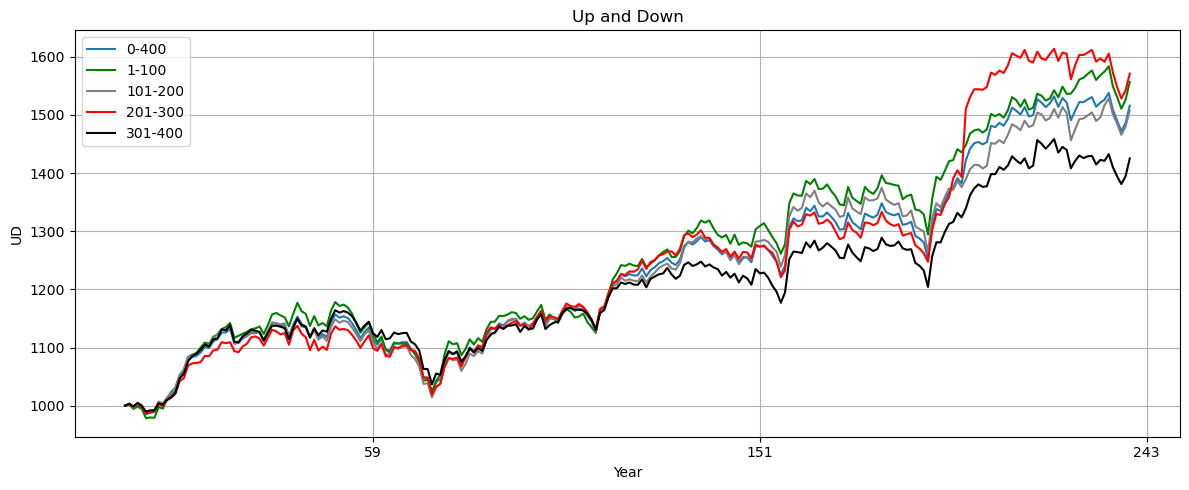

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(df_pic.index, df_pic['index'], linestyle='-', label='0-400')
plt.plot(df_pic1.index, df_pic1['index'], linestyle='-', color='green', label='1-100')
plt.plot(df_pic2.index, df_pic2['index'], linestyle='-', color='grey', label='101-200')
plt.plot(df_pic3.index, df_pic3['index'], linestyle='-', color='red', label='201-300')
plt.plot(df_pic4.index, df_pic4['index'], linestyle='-', color='black', label='301-400')


# plt.xlim(['2023-12-01', '2023-12-19'])

# 设置间隔为一个月
months = MonthLocator(interval=3) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Up and Down')
plt.xlabel('Year')
plt.ylabel('UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()